> https://www.analyticsvidhya.com/blog/2021/12/multiclass-classification-using-transformers/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [ ]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

### **데이터셋 가져오기**

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/no_nan_qna_set.csv', index_col=0)
# df = pd.read_table('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/moonee_qna_set.txt', sep=',', index_col=0)
# df.head()

### **불용어제거**
> `ex_12_version_2._stopwords.ipynb` 참조
> - okt 형태소 분석기를 이용해 inquiry를 토큰화해 단어 사전을 만들었다.
> - 토큰화된 단어들을 빈도순으로 나열했고, 그 중 `인입`, `문의`, `요청`, `확인` 이라는 명사들은 자주 등장하지만 필요한 단어가 아니라고 판단해 제거하기로 판단했다.
>> `요청` -> 사고조사 vs. 블랙박스 구분하는데 필요하다고 판단

In [ ]:
# 불용어 제거 -> re.sub으로 다중 공백 제거
import re

new_memo = []
for i in range(len(df)):
    sentence = re.split("[\n | / | ) | , | _ | 재인입 | 인입 | 문의 | 요청 | 확인]", df['inquiry'][i]) # 그냥 split은 여러개 안돼서, re.split 사용
    temp = ' '.join(sentence)
    temp = re.sub(r"\s+", " ", temp).strip()
    new_memo.append(temp)

df['inquiry'] = new_memo

### **오버샘플링 적용**
> 해당 데이터는 `class imbalance`의 문제가 심함
> - 제일 많은 `내비게이션` 데이터는 1058개, 제일 적은 `충전기확인` 데이터는 4개 뿐
> - **RandomOverSampling**을 이용해 데이터를 복제해 최대 갯수인 1058개에 맞추자.

In [ ]:
df['sub_type'].value_counts()

내비게이션      1058
타이어         675
시동          672
경고등         642
라이트         583
차량외부        389
차량내부        368
주행관련        348
하이패스        199
후방카메라       190
단말기         180
주유/충전카드     158
브레이크        142
블랙박스         90
주차장          48
위생문제         46
차량점검         13
사고조사         11
비치품          10
ADAS         10
충전기확인         4
Name: sub_type, dtype: int64

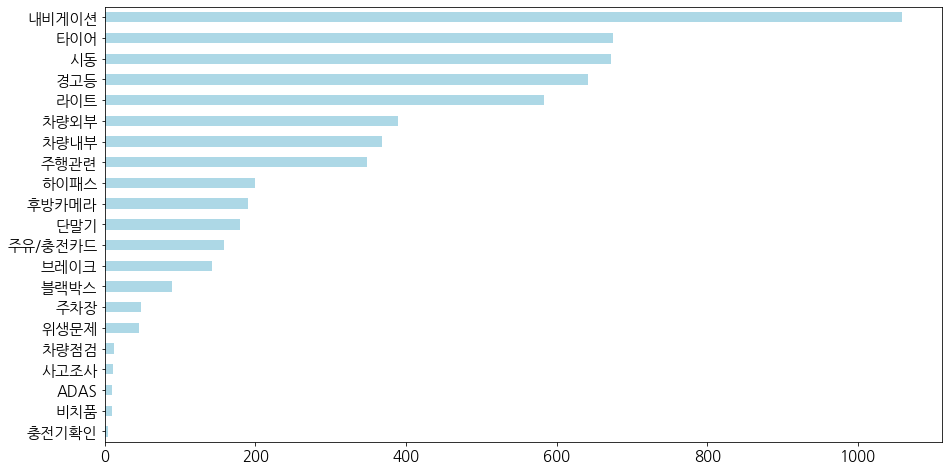

In [ ]:
df['sub_type'].value_counts(ascending=True).plot.barh(figsize=(15, 8), fontsize=15, color='lightblue')

In [ ]:
# 특징과 label 분리
X = df.drop('sub_type', axis=1)
y = df['sub_type']

In [ ]:
X.shape, y.shape

((5836, 2), (5836,))

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# 인스턴스 생성
method = RandomOverSampler()

# 오버샘플링 적용
X, y = method.fit_resample(X, y)

X = pd.DataFrame(X, columns=X.columns)
y = pd.Series(y)

In [ ]:
df = pd.concat([X, y], axis=1) # 데이터프레임(X)와 시리즈(y) 합치기

In [ ]:
df['sub_type'].value_counts()

브레이크       1058
타이어        1058
ADAS       1058
충전기확인      1058
주차장        1058
비치품        1058
위생문제       1058
차량점검       1058
차량외부       1058
단말기        1058
후방카메라      1058
경고등        1058
하이패스       1058
주유/충전카드    1058
내비게이션      1058
블랙박스       1058
차량내부       1058
주행관련       1058
라이트        1058
시동         1058
사고조사       1058
Name: sub_type, dtype: int64

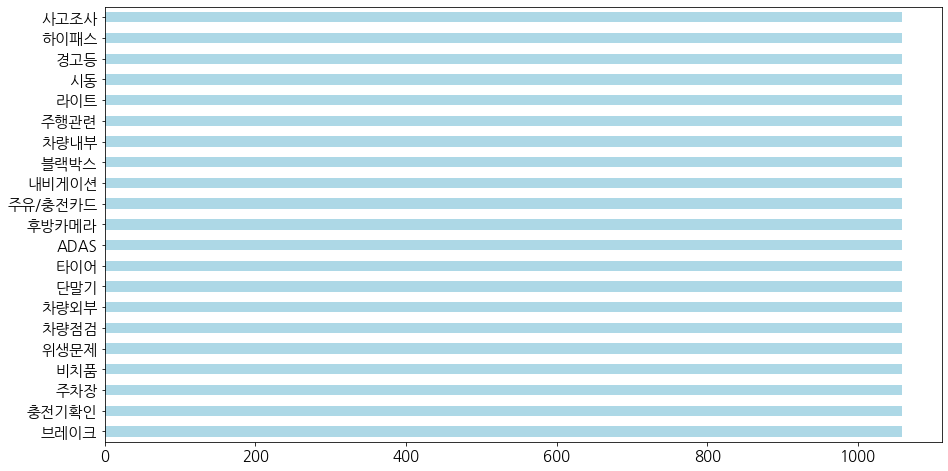

In [ ]:
df['sub_type'].value_counts(ascending=True).plot.barh(figsize=(15, 8), fontsize=15, color='lightblue')

---

### **SMOTE**

In [ ]:
# # X = df.drop('sub_type', axis=1)
# X = df[['inquiry']]
# y = df['sub_type']

In [ ]:
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()
# vectorizer.fit(X_train.values.ravel())
# X_train = vectorizer.transform(X_train.values.ravel())
# X_test = vectorizer.transform(X_test.values.ravel())
# X_train = X_train.toarray()
# X_test = X_test.toarray()

# x_train = pd.DataFrame(X_train)
# X_resample, y_resampled = SMOTE().fit_resample(X_train, y_train)

# X_resample = pd.DataFrame(X_resample)
# y_resampled = pd.Series(y_resampled)

In [ ]:
# df =  pd.concat([X_resample, y_resampled], axis=1)
# df

In [ ]:
X.shape, y.shape

((5848, 1), (5848,))

### **train, test set 분리**

In [ ]:
from sklearn.model_selection import train_test_split

# train_test_split
df_train, df_test = train_test_split(df,
                                     test_size=0.2,
                                     shuffle=True,
                                     random_state=930,
                                     stratify=df['sub_type'].values)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
df_train['sub_type'].nunique(), df_test['sub_type'].nunique()

(21, 21)

### **sub_type을 categorical data로**

In [ ]:
# 정수 인코딩
sub_type_mapping = {
    '내비게이션': 0,
    '타이어': 1,
    '라이트': 2,
    '시동': 3,
    '경고등': 4,
    '차량외부': 5,
    '차량내부': 6,
    '주행관련': 7,
    '사고조사': 8,
    '단말기': 9,
    '주유/충전카드': 10,
    '후방카메라': 11,
    '하이패스': 12,
    '차량점검': 13,
    '브레이크': 14,
    '블랙박스': 15,
    '위생문제': 16,
    '주차장': 17,
    'ADAS': 18,
    '비치품': 19,
    '충전기확인': 20
}

func = lambda x: sub_type_mapping.get(x, x)

In [ ]:
df_train['sub_type'] = df_train['sub_type'].map(func)
df_test['sub_type'] = df_test['sub_type'].map(func)

In [ ]:
# target data를 categorical 형태로 변환
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(df_train['sub_type'])
y_test = to_categorical(df_test['sub_type'])

### **트랜스포머**

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 64.3 MB/s 
     |████████████████████████████████| 6.6 MB 43.9 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


> - `AutoTokenizer`: 다양한 타입의 tokenizer 포함
> - `TFBertModel`: 텐서플로우에서 사용하는 pre-trained된 Bert
>> 한국어를 사용하기 위해 100개 이상의 언어로 사전학습된 **`bert-base-multilingual-cased`** BERT를 이용하자.

In [ ]:
# import transformers
# from transformers import AutoTokenizer, TFBertModel

# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# bert = TFBertModel.from_pretrained('bert-base-cased')

In [ ]:
import transformers
from transformers import AutoTokenizer, TFBertModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
bert = TFBertModel.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
tokenizer.tokenize('I have a new GPU!')

['I', 'have', 'a', 'new', 'GPU', '!']

In [ ]:
tokenizer.tokenize('내비게이션이 잘 안 됩니다!')

['내', '##비', '##게', '##이션', '##이', '잘', '안', '[UNK]', '!']

### **Input Data Modeling**
> Input 텍스트 데이터를 tokenizer를 사용해 Bert의 input 형식으로 맞추자.

In [ ]:
x_train = tokenizer(
    text = df_train['inquiry'].tolist(),
    add_special_tokens=True, # CLS, SEP
    max_length=70, # 각 sentence의 최대 길이. 이보다 크면 잘리고 작으면 padding될 것.
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False, # 여기서 필요하지 x
    return_attention_mask=True, # input으로 attention_mask를 포함시키고 싶음
    verbose=True
)

x_test = tokenizer(
    text=df_test['inquiry'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose = True
)

> data modeling이후 tokenizer은 `input_ids`와 `attention_mask`를 key로 갖는 dictionary를 반환

> tokenizer에 tex를 넣고 item을 출력해보면
> - input_ids: 우리의 input 토큰에 대해 vocab dic의 key 값을 출력
> - attention_mask: special token인지 아닌지 출력해줌
> - token_type_ids: 0번째 문장인지, 1번째 문장인지에 대해 출력

In [ ]:
# print(x_train[0].tokens)

In [ ]:
print(x_train[0].ids)

[101, 9730, 44321, 9521, 71013, 35465, 20309, 9309, 14646, 119248, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(x_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
x_train

{'input_ids': <tf.Tensor: shape=(17774, 70), dtype=int32, numpy=
array([[   101,   9730,  44321, ...,      0,      0,      0],
       [   101,   9730,  44321, ...,      0,      0,      0],
       [   101,   9560, 119045, ...,      0,      0,      0],
       ...,
       [   101,   9580,  66016, ...,      0,      0,      0],
       [   101,   9952,  10739, ...,      0,      0,      0],
       [   101,   9730,  44321, ...,      0,      0,      0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(17774, 70), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
input_ids = x_train['input_ids'] # input 토큰에 대한 key
attention_mask = x_train['attention_mask'] # special token인지 아닌지

### **Model Building**
> functional API 사용

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [ ]:
max_len = 70

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids, attention_mask=input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)
y = Dense(21, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

### **모델 Compilation**
> parameter 정의하고, model compile하기

In [ ]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model, taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy') # 모든 class들에 대해 평균 accuarcy

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss, 
    metrics=metric)

### **모델 Training**
> x_test는 전처리 이후 `input_ids`, `attention_mask`를 포함해 사전 형태가 되었다.
> - 이 두 값을 training을 위해 사용하자.

In [ ]:
train_history = model.fit(
    x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']},
    y = y_train,
    validation_data = (
    {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, y_test
    ),
  epochs=10,
  batch_size=36
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


494/494 [==============================] - 232s 403ms/step - loss: 0.9509 - balanced_accuracy: 0.7533 - val_loss: 0.4667 - val_balanced_accuracy: 0.8778
Epoch 2/10
494/494 [==============================] - 195s 395ms/step - loss: 0.3894 - balanced_accuracy: 0.8983 - val_loss: 0.3643 - val_balanced_accuracy: 0.9021
Epoch 3/10
494/494 [==============================] - 195s 395ms/step - loss: 0.2978 - balanced_accuracy: 0.9203 - val_loss: 0.3104 - val_balanced_accuracy: 0.9183
Epoch 4/10
494/494 [==============================] - 195s 394ms/step - loss: 0.2450 - balanced_accuracy: 0.9339 - val_loss: 0.2888 - val_balanced_accuracy: 0.9271
Epoch 5/10
494/494 [==============================] - 195s 394ms/step - loss: 0.2194 - balanced_accuracy: 0.9420 - val_loss: 0.2716 - val_balanced_accuracy: 0.9323
Epoch 6/10
494/494 [==============================] - 195s 394ms/step - loss: 0.1974 - balanced_accuracy: 0.9474 - val_loss: 0.2542 - val_balanced_accuracy: 0.9381
Epoch 7/10
494/494 [=======

### **모델 평가**

In [ ]:
predicted_raw = model.predict({'input_ids': x_test['input_ids'],
                               'attention_mask': x_test['attention_mask']})
predicted_raw[0]

array([4.6562453e-04, 1.3867983e-03, 4.2751708e-04, 2.2600601e-05,
       3.5919937e-05, 3.4088811e-03, 1.9524482e-04, 2.2290130e-04,
       1.7716145e-04, 5.1393085e-03, 8.8661058e-05, 1.0260005e-03,
       1.8860769e-06, 8.7688316e-04, 2.3279838e-04, 1.3764584e-04,
       3.0013989e-06, 9.8594207e-01, 1.2608549e-04, 6.5246189e-07,
       8.2433071e-05], dtype=float32)

In [ ]:
# maximum 확률값을 가지는 value의 index
y_predicted = np.argmax(predicted_raw, axis=1)
y_true = df_test['sub_type']

### **성능 지표**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       212
           1       0.91      0.87      0.89       212
           2       0.90      0.83      0.86       211
           3       0.93      0.81      0.87       212
           4       0.86      0.85      0.86       212
           5       0.94      0.89      0.91       211
           6       0.89      0.92      0.91       212
           7       0.87      0.90      0.89       212
           8       1.00      1.00      1.00       212
           9       0.77      0.97      0.86       211
          10       0.96      1.00      0.98       212
          11       0.97      0.95      0.96       212
          12       1.00      0.98      0.99       211
          13       1.00      1.00      1.00       211
          14       0.97      0.99      0.98       211
          15       0.98      1.00      0.99       212
          16       0.97      1.00      0.99       212
          17       0.99    

### **Prediction Pipeline**

In [ ]:
sub_type_mapping_new = dict(zip(sub_type_mapping.values(), sub_type_mapping.keys()))
sub_type_mapping_new

{0: '내비게이션',
 1: '타이어',
 2: '라이트',
 3: '시동',
 4: '경고등',
 5: '차량외부',
 6: '차량내부',
 7: '주행관련',
 8: '사고조사',
 9: '단말기',
 10: '주유/충전카드',
 11: '후방카메라',
 12: '하이패스',
 13: '차량점검',
 14: '브레이크',
 15: '블랙박스',
 16: '위생문제',
 17: '주차장',
 18: 'ADAS',
 19: '비치품',
 20: '충전기확인'}

In [ ]:
# sub_type_mapping_new = {v: k in k, v in sub_type_mapping.items()}

> 데이터를 training data와 같은 형식으로 변환하고 `model.predict()`를 불러줘야 한다.

In [ ]:
while(1):
    texts = input(str('input the text: '))
    if texts == '.':
        break

    x_val = tokenizer(
        text=texts,
        add_special_tokens=True,
        max_length=70,
        truncation=True,
        padding='max_length', 
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose = True)

    validation = model.predict({'input_ids': x_val['input_ids'],
                                'attention_mask': x_val['attention_mask']})*100

    score = (-validation).argsort()
    for i in score[0]:
        print(sub_type_mapping_new.get(i), '  ', validation[0][i])

# for key, value in zip(sub_type_mapping.get(score[0]), validation[0]):
#     print(key, value)

input the text: 내비게이션이 잘 안 됩니다.
내비게이션    95.77037
차량내부    1.8948061
주유/충전카드    1.1969036
브레이크    0.3479428
타이어    0.17358525
경고등    0.14344649
라이트    0.13497692
차량외부    0.08724291
차량점검    0.07286381
사고조사    0.05174095
단말기    0.048513625
주차장    0.0379753
위생문제    0.014331016
주행관련    0.010206648
후방카메라    0.0060257195
하이패스    0.0055169957
시동    0.0019978986
블랙박스    0.0005635149
ADAS    0.00042367273
비치품    0.00033482205
충전기확인    0.00023487928
input the text: .
